## LIBRARIES

In [1]:
import pandas as pd
import numpy as np

import pywt
from scipy.fftpack import fft,ifft,fftfreq
from scipy.signal import butter, lfilter, filtfilt, lfiltic , iirpeak, freqs, welch, iirfilter, hilbert

from scipy.signal import find_peaks, argrelextrema
from scipy.stats import norm, gamma, chi2, kurtosis, skew, stats

import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

## IMPORT DATA ON A DATAFRAME

In [2]:
filename1 = "center_sternum.txt"
data_read = pd.read_table(filename1)

# Full data as dataframe
data = pd.DataFrame(data_read)

# Frequency
Freq = data['Log Freq'][1]              

# Reconstructing Real_Time
Time_stamp = data[['Timestamp']]        
data_time = pd.DataFrame(np.asarray(range(len(Time_stamp)))*(1/Freq), columns=['Time'])

# Acc & Gyro data on the three axis
data_ag = pd.concat([data_time,data[['AccX','AccY','AccZ']], data[['GyroX','GyroY','GyroZ']]],axis=1)

### FIRST PLOT VIEW

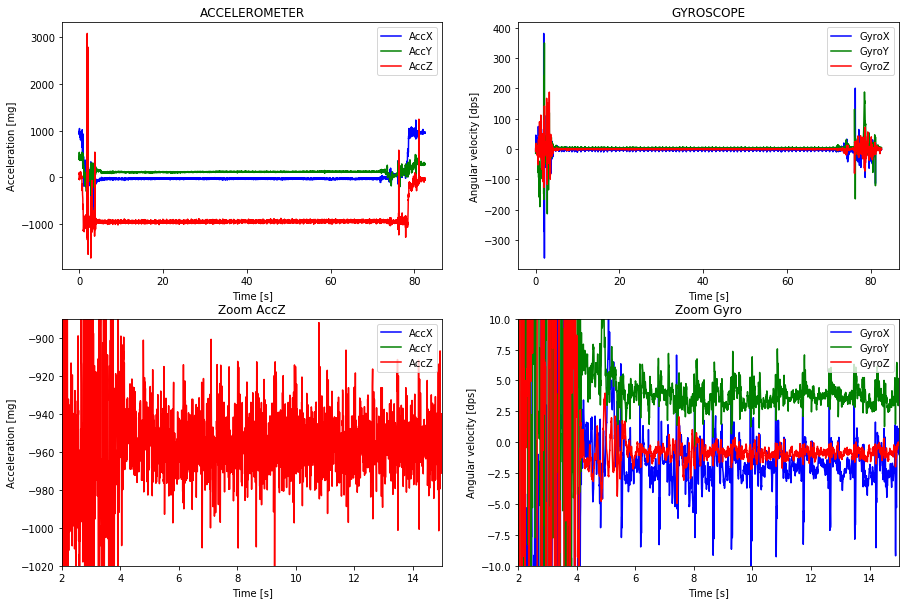

In [3]:
fig, axs = plt.subplots(2,2,figsize = (15,10))

axs[0,0].plot(data_ag['Time'],data_ag['AccX'],'b-',label='AccX')
axs[0,0].plot(data_ag['Time'],data_ag['AccY'],'g-',label='AccY')
axs[0,0].plot(data_ag['Time'],data_ag['AccZ'],'r-',label='AccZ')
axs[0,0].set_title( "ACCELEROMETER")
axs[0,0].set_ylabel("Acceleration [mg]")
axs[0,0].set_xlabel('Time [s]')
axs[0,0].legend(loc=1)
######################################################################
axs[0,1].plot(data_ag['Time'],data_ag['GyroX'],'b-',label='GyroX')
axs[0,1].plot(data_ag['Time'],data_ag['GyroY'],'g-',label='GyroY')
axs[0,1].plot(data_ag['Time'],data_ag['GyroZ'],'r-',label='GyroZ')
axs[0,1].set_title( "GYROSCOPE")
axs[0,1].set_ylabel("Angular velocity [dps]")
axs[0,1].set_xlabel('Time [s]')
axs[0,1].legend(loc=1)
######################################################################
axs[1,0].plot(data_ag['Time'],data_ag['AccX'],'b-',label='AccX')
axs[1,0].plot(data_ag['Time'],data_ag['AccY'],'g-',label='AccY')
axs[1,0].plot(data_ag['Time'],data_ag['AccZ'],'r-',label='AccZ')
axs[1,0].set_title( "Zoom AccZ")
axs[1,0].set_ylabel("Acceleration [mg]")
axs[1,0].set_xlabel('Time [s]')
axs[1,0].set_ylim([-1020,-890])
axs[1,0].set_xlim([2,15])
axs[1,0].legend(loc=1)
#####################################################################
axs[1,1].plot(data_ag['Time'],data_ag['GyroX'],'b-',label='GyroX')
axs[1,1].plot(data_ag['Time'],data_ag['GyroY'],'g-',label='GyroY')
axs[1,1].plot(data_ag['Time'],data_ag['GyroZ'],'r-',label='GyroZ')
axs[1,1].set_title( "Zoom Gyro")
axs[1,1].set_ylabel("Angular velocity [dps]")
axs[1,1].set_xlabel('Time [s]')
axs[1,1].set_ylim([-10,10])
axs[1,1].set_xlim([2,15])
axs[1,1].legend(loc=1)
plt.savefig('FirstFigure.png', bbox_inches = "tight")

### Selecting window for data  

In [4]:
data_small_ag = data_ag[(data_ag['Time'] >= 10) & (data_ag['Time'] < 70)]
df_describe = data_small_ag.describe()
df_describe = df_describe.rename(columns={"Time": "Time [s]", "AccX": "AccX [mg]", "AccY": "AccY [mg]", "AccZ": "AccZ [mg]", "GyroX": "GyroX [rad/s]", "GyroY": "GyroY [rad/s]", "GyroZ": "GyroZ [rad/s]"})
df_describe.round(1)
df_descrive = df_describe.iloc[:,1:].round(1)
df_descrive

,AccX [mg],AccY [mg],AccZ [mg],GyroX [rad/s],GyroY [rad/s],GyroZ [rad/s]
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,-30.7,115.6,-949.1,-2.1,3.7,-0.9
std,7.0,5.3,14.4,1.4,0.7,0.4
min,-66.9,85.8,-1015.5,-10.0,0.5,-2.5
25%,-35.3,112.1,-957.6,-2.7,3.3,-1.1
50%,-30.6,115.7,-949.5,-2.2,3.6,-0.9
75%,-26.0,119.1,-941.3,-1.5,4.0,-0.6
max,-5.4,147.4,-879.7,4.5,7.6,0.6


## Functions

### FFT & PSD

In [5]:
def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)      
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])     
    return f_values, fft_values

def get_psd_values(y_values, T, N, f_s):
    f_values, psd_values = welch(y_values, fs=f_s)
    return f_values, psd_values

def FFT_analysis(y_values, T, length_data):                        #Fourier for Filter
    x_FFT = np.fft.fftfreq(length_data, T)
    y_FFT = np.fft.fft(y_values)
    df_FFT = pd.DataFrame({'Freq':x_FFT, 'Amplitude':y_FFT})
    return df_FFT

def FFT_filter(df_FFT, Freq_min, Freq_max):                       #Filtering using a Fourier intervall
    df_FFT[df_FFT['Freq'].abs() < Freq_min] = 0
    df_FFT[df_FFT['Freq'].abs() > Freq_max] = 0
    Antitransform = np.fft.ifft(df_FFT['Amplitude'])
    return Antitransform


## FILTER

In [6]:
def my_filter(filter_order, frequency_in, filter_type ,sampling_freq_system, data_in):
    b,a = butter(filter_order,frequency_in, filter_type, fs = sampling_freq_system)
    frequency_responsew,h = freqs(b,a)
    data_filtered = filtfilt(b,a, data_in) 
    return data_filtered

def my_narrow(frequency_in , fs , quality_factor, data_in):
    w0 = frequency_in/(fs/2)
    b, a = iirpeak(w0, quality_factor)
    data_filtered = filtfilt(b,a, data_in)  
    return data_filtered

def iir_filter(filter_order, frequency_in, filter_type , design, data_in, sampling_freq_system):
    b,a = iirfilter(filter_order,frequency_in, btype=filter_type, ftype=design, fs=sampling_freq_system)
    data_filtered = filtfilt(b,a, data_in)
    return data_filtered


## Finding maxima

In [7]:
def maxima_minima(time, filtereddata):
    df_filter = pd.DataFrame({'Time':time, 'Filtered':filtereddata})
    df_filter['min'] = df_filter.iloc[argrelextrema(df_filter.Filtered.values, np.less_equal, order=1)[0]]['Filtered']
    df_filter['max'] = df_filter.iloc[argrelextrema(df_filter.Filtered.values, np.greater_equal, order=1)[0]]['Filtered']
    return df_filter

def find_min(df_filter):
    time_max_array = df_filter[['Time', 'min']]
    value_best = time_max_array.dropna() 
    difference = value_best.diff()
    return difference.dropna()
    
def find_max(df_filter):
    time_max_array = df_filter[['Time', 'max']]
    value_best = time_max_array.dropna() 
    difference = value_best.diff()
    return difference.dropna()

# FFT analysis

## Accelerometer

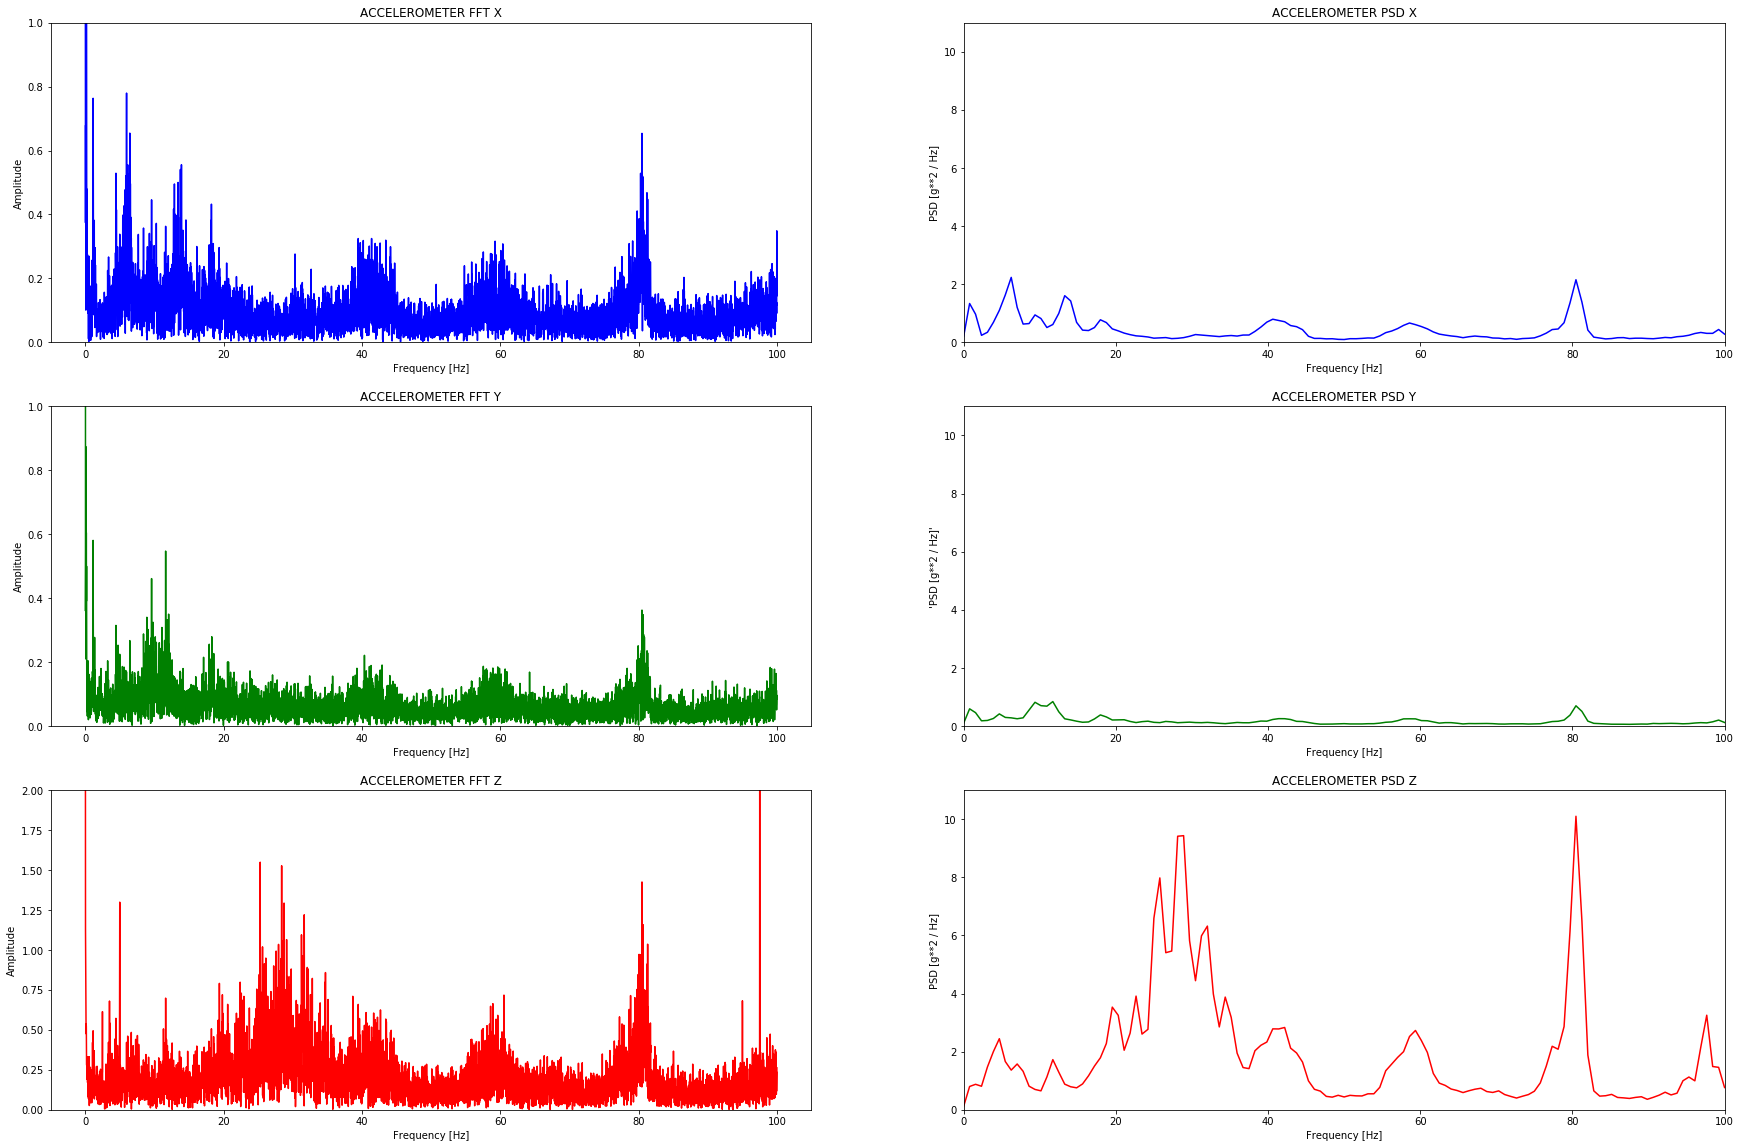

In [8]:
N = data_small_ag.shape[0]
T = 1/Freq   
f_s = Freq   

f_values, fft_values = get_fft_values(data_small_ag['AccX'], T, N, f_s)
f_values_psd, psd_values = get_psd_values(data_small_ag['AccX'], T, N, f_s)

f_values_g, fft_values_g = get_fft_values(data_small_ag['AccY'], T, N, f_s)
f_values_psd_g, psd_values_g = get_psd_values(data_small_ag['AccY'], T, N, f_s)

f_values_z, fft_values_z = get_fft_values(data_small_ag['AccZ'], T, N, f_s)
f_values_psd_z, psd_values_z = get_psd_values(data_small_ag['AccZ'], T, N, f_s)

#PLOT
fig, axs = plt.subplots(3,2,figsize = (30,20))
axs[0,0].plot(f_values,fft_values,'b')
axs[0,0].set_title( "ACCELEROMETER FFT X")
axs[0,0].set_ylim([0,1])
axs[0,0].set_ylabel("Amplitude")
axs[0,0].set_xlabel('Frequency [Hz]')
axs[0,1].plot(f_values_psd, psd_values, linestyle='-', color='blue')
axs[0,1].set_title("ACCELEROMETER PSD X")
axs[0,1].axis([0,100,0,11])
axs[0,1].set_ylabel("PSD [g**2 / Hz]")
axs[0,1].set_xlabel('Frequency [Hz]')
##############################################
axs[1,0].plot(f_values_g,fft_values_g,'g')
axs[1,0].set_title( "ACCELEROMETER FFT Y")
axs[1,0].set_ylim([0,1])
axs[1,0].set_ylabel("Amplitude")
axs[1,0].set_xlabel('Frequency [Hz]')
axs[1,1].plot(f_values_psd_g, psd_values_g, linestyle='-', color='g')
axs[1,1].axis([0,100,0,11])
axs[1,1].set_title("ACCELEROMETER PSD Y")
axs[1,1].set_ylabel("'PSD [g**2 / Hz]'")
axs[1,1].set_xlabel('Frequency [Hz]')
##############################################
axs[2,0].plot(f_values_z,fft_values_z,'r')
axs[2,0].set_title( "ACCELEROMETER FFT Z")
axs[2,0].set_ylim([0,2])
axs[2,0].set_ylabel("Amplitude")
axs[2,0].set_xlabel('Frequency [Hz]')
axs[2,1].plot(f_values_psd_z, psd_values_z, linestyle='-', color='r')
axs[2,1].set_title("ACCELEROMETER PSD Z")
axs[2,1].axis([0,100,0,11])
axs[2,1].set_ylabel("PSD [g**2 / Hz]")
axs[2,1].set_xlabel('Frequency [Hz]')
plt.savefig('FFT_ACC.png', bbox_inches = "tight")

#### mean value AccZ

In [9]:
mean_ampl_acc1 = data_small_ag[['AccZ']].mean()
mean_ampl_AccZ = mean_ampl_acc1[0]

## Filter AccZ

In [10]:
######################################################################################
result_3 = iir_filter(4, [25,35] , 'bandpass', 'butter', data_small_ag['AccZ'], 200)
######################################################################################

#result_1 = my_filter(5, 20 , 'low', 200, data_small_ag['AccZ'])
#result_2 = my_filter(3, [20,25] , 'band', 200, data_small_ag['AccZ'])
#result_3 = my_filter(5, [1,10] , 'band', 200, data_small_ag['AccZ'])
#result_3 = iir_filter(4, [25,35] , 'bandpass', 'butter', data_small_ag['AccZ'], 200)
#result_4 = iir_filter(3, [1,30] , 'bandpass', 'butter', data_small_ag['AccZ'], 200)

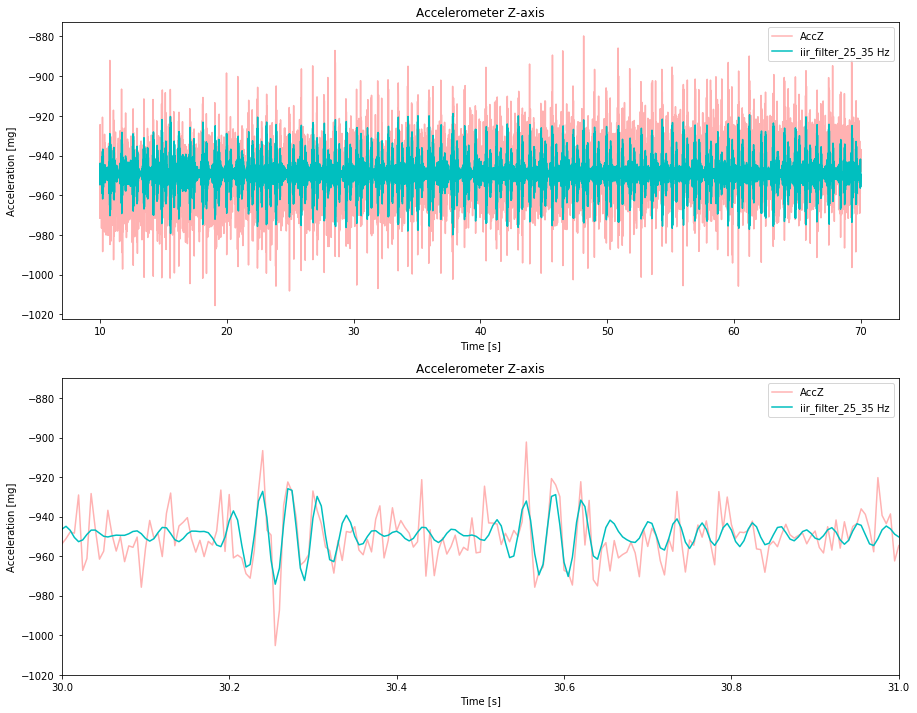

In [11]:
fig, axs = plt.subplots(2,1,figsize = (15,12))

######################################################################
axs[0].plot(data_small_ag['Time'],data_small_ag['AccZ'],'r', alpha = 0.3)
axs[0].plot(data_small_ag['Time'], result_3 + mean_ampl_AccZ,'c',label='iir_filter_25_35 Hz')
axs[0].set_ylabel("Acceleration [mg]")
axs[0].set_xlabel('Time [s]')
axs[0].set_title('Accelerometer Z-axis')
axs[0].legend(loc='upper right')
######################################################################
axs[1].plot(data_small_ag['Time'],data_small_ag['AccZ'],'r', alpha = 0.3)
axs[1].plot(data_small_ag['Time'], result_3 + mean_ampl_AccZ,'c',label='iir_filter_25_35 Hz')
axs[1].set_xlim([30,31])
axs[1].set_ylim([-1020,-870])
axs[1].set_ylabel("Acceleration [mg]")
axs[1].set_xlabel('Time [s]')
axs[1].set_title('Accelerometer Z-axis')
axs[1].legend(loc='upper right')
plt.savefig('IIR_25_35_filter.png', bbox_inches = "tight")

## Envelope

In [12]:
hilb_prv = hilbert(result_3)
amplitude_envelope = np.abs(hilb_prv)

maxima_acc_Z = maxima_minima(data_small_ag['Time'], amplitude_envelope + mean_ampl_AccZ)

x = np.arange(0, 100000,1)

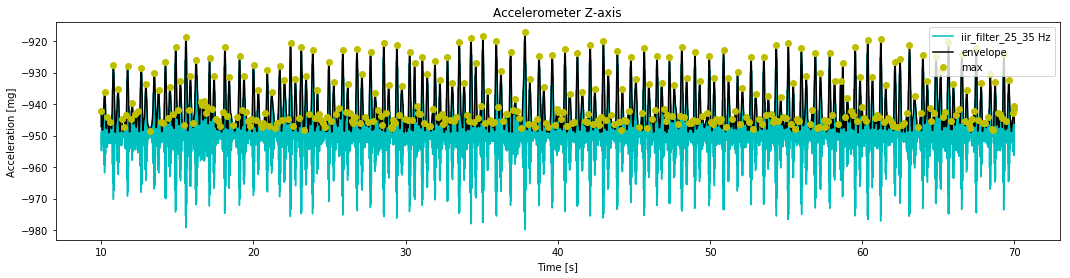

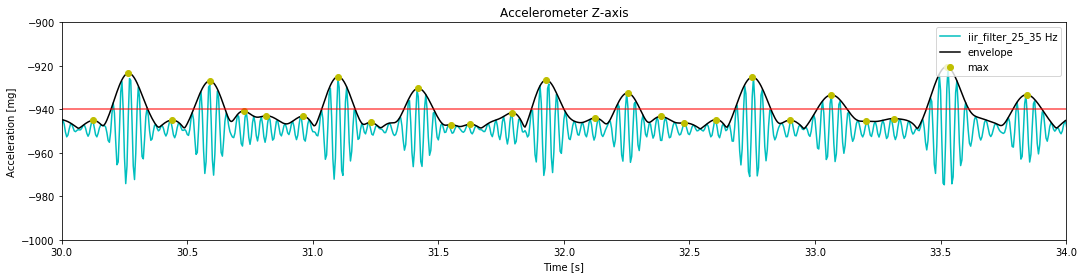

<Figure size 432x288 with 0 Axes>

In [13]:
plt.figure
fig = plt.figure(figsize=(18,4))
######################################################################
plt.plot(data_small_ag['Time'], result_3 + mean_ampl_AccZ,'c', label='iir_filter_25_35 Hz')
plt.plot(data_small_ag['Time'], amplitude_envelope+mean_ampl_AccZ,'k',label='envelope')
plt.plot(maxima_acc_Z['Time'], maxima_acc_Z['max'],'yo',label='max')
plt.ylabel("Acceleration [mg]")
plt.xlabel('Time [s]')
plt.title('Accelerometer Z-axis')
plt.legend(loc='upper right')
plt.show()
plt.savefig('Maximi_first_filtered1.png', bbox_inches = "tight")
plt.close()

plt.figure
fig = plt.figure(figsize=(18,4))
######################################################################
plt.plot(data_small_ag['Time'], result_3 + mean_ampl_AccZ,'c', label='iir_filter_25_35 Hz')
plt.plot(data_small_ag['Time'], amplitude_envelope+mean_ampl_AccZ,'k',label='envelope')
plt.xlim([30,34])
plt.ylim([-1000,-900])
plt.plot(maxima_acc_Z['Time'], maxima_acc_Z['max'],'yo',label='max')
plt.ylabel("Acceleration [mg]")
plt.xlabel('Time [s]')
plt.axhline(-940, color = 'r', alpha = 0.7)
plt.title('Accelerometer Z-axis')
plt.legend(loc='upper right')

plt.show()


plt.savefig('Maximi_first_filtered2.png', bbox_inches = "tight")

In [14]:
Filtered = pd.DataFrame([data_small_ag['Time'].values, result_3, amplitude_envelope]).T
Filtered.columns = ["Time","AccZ","Amp_envelope"]

#Filtered + Hilbert Transform
maximum = np.max(Filtered["Amp_envelope"])
minimum = np.min(Filtered["Amp_envelope"])


# nromalization i do not know if it is the best thing to do 
Filtered["Amp_envelope"]= (Filtered["Amp_envelope"] - minimum)/(maximum - minimum)
Filtered["AccZ"]= (Filtered["AccZ"] - minimum)/(maximum - minimum)

Filtered.describe()

,Time,AccZ,Amp_envelope
count,12000.00000,12000.000000,12000.000000
mean,39.99750,-0.001021,0.241325
std,17.32123,0.229190,0.215260
min,10.00000,-0.969368,0.000000
25%,24.99875,-0.091210,0.086462
50%,39.99750,-0.001236,0.151155
75%,54.99625,0.088821,0.353700
max,69.99500,0.950750,1.000000


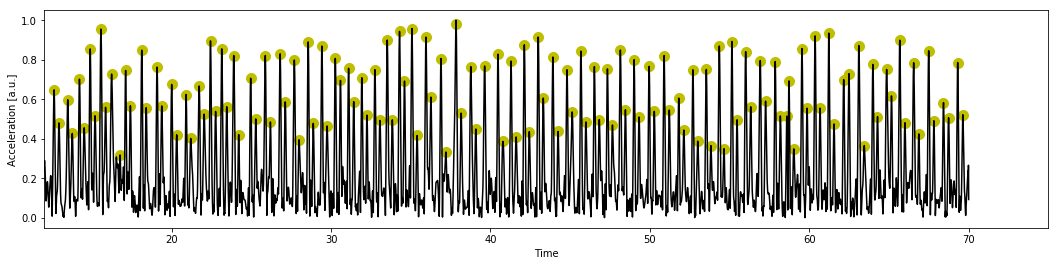

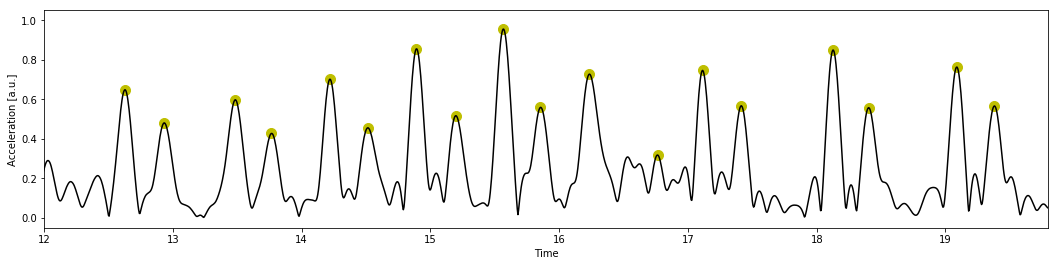

In [15]:
threshold = 0.31508
plt.figure
fig = plt.figure(figsize=(18,4))
fragment = Filtered[(Filtered['Time'] >= 12) & (Filtered['Time'] < 75)]
fragment1 = fragment[(fragment['Amp_envelope'] >= threshold) & (fragment['Amp_envelope'] <= 0.99)]
bbbb = maxima_minima(fragment1['Time'].values, fragment1['Amp_envelope'].values)

maxima = bbbb[['Time','max']].dropna()

plt.plot(maxima['Time'], maxima['max'], 'yo', markersize = 10)
plt.plot(Filtered['Time'],Filtered["Amp_envelope"],'k',label='envelope')
plt.xlim([12,75])
plt.ylabel('Acceleration [a.u.]')
plt.xlabel("Time")
plt.show()

plt.figure
fig = plt.figure(figsize=(18,4))
plt.plot(maxima['Time'], maxima['max'], 'yo', markersize = 10)
plt.plot(Filtered['Time'],Filtered["Amp_envelope"],'k',label='envelope')
plt.xlim([12,19.8])
plt.ylabel('Acceleration [a.u.]')
plt.xlabel("Time")

plt.show()

In [16]:
#################################################################################
##########labels larger maxima and minima according the the adjacent ones########
#################################################################################

def max_min(dataframe, relative_perc = 0):
    maxima_lst = []
    
    for index in range(0, len(dataframe)):
        score = 0
        
        #first point label as undefined since we can't see previous one
        if (index == 0):
            maxima_lst.append(-1)
            continue
        #last point label as undefined since we can't see following one
        if (index == len(dataframe) - 1):
            maxima_lst.append(-1)
            continue
        
        #see whether previous point is larger or smaller
        if (dataframe['max'].iat[index]) > (dataframe['max'].iat[index - 1] +  relative_perc ):
            score += 1       
            
        #see whether following point is larger or smaller
        if (dataframe['max'].iat[index]) > (dataframe['max'].iat[index + 1] +  relative_perc ):
            score += 1        
        
        if (score == 0):
            maxima_lst.append(0) #it is smaller peak
        elif (score == 1):
            maxima_lst.append(-1) #it is undefined peak (missing larger or smaller one)
        elif (score == 2):
            maxima_lst.append(1) #it is larger peak
    
    return maxima_lst


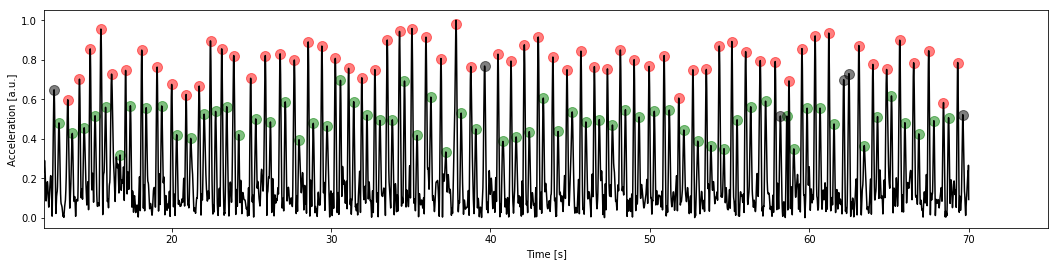

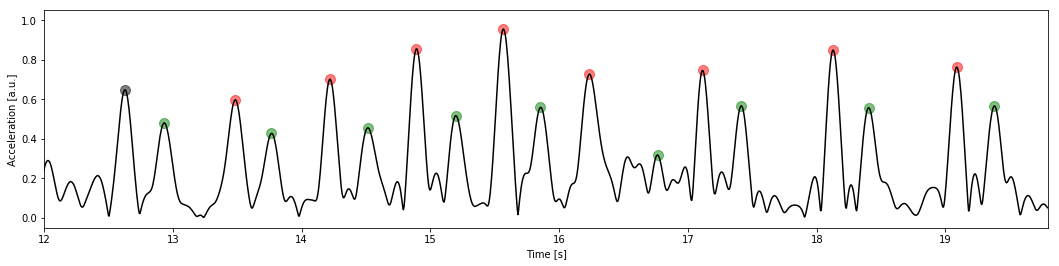

In [17]:
maxima_mask =  max_min(maxima)
maxima_labeled = maxima
maxima_labeled['labels'] = maxima_mask
maxima_labeled

#for plots
large_peaks = maxima_labeled[maxima_labeled['labels'] ==  1 ]
small_peaks = maxima_labeled[maxima_labeled['labels'] ==  0 ] 
undef_peaks = maxima_labeled[maxima_labeled['labels'] == -1 ]

plt.figure
fig = plt.figure(figsize=(18,4))
plt.plot(large_peaks['Time'], large_peaks['max'], 'ro', markersize = 10, alpha = 0.5)
plt.plot(small_peaks['Time'], small_peaks['max'], 'go', markersize = 10, alpha = 0.5)
plt.plot(undef_peaks['Time'], undef_peaks['max'], 'ko', markersize = 10, alpha = 0.5)
plt.plot(Filtered['Time'],Filtered["Amp_envelope"],'k',label='envelope')
plt.ylabel('Acceleration [a.u.]')
plt.xlabel("Time [s]")
plt.xlim([12,75])
plt.show()

plt.figure
fig = plt.figure(figsize=(18,4))
plt.plot(large_peaks['Time'], large_peaks['max'], 'ro', markersize = 10, alpha = 0.5)
plt.plot(small_peaks['Time'], small_peaks['max'], 'go', markersize = 10, alpha = 0.5)
plt.plot(undef_peaks['Time'], undef_peaks['max'], 'ko', markersize = 10, alpha = 0.5)
plt.plot(Filtered['Time'],Filtered["Amp_envelope"],'k',label='envelope')
plt.xlim([12,19.8])
plt.ylabel('Acceleration [a.u.]')
plt.xlabel("Time [s]")
plt.show()

In [18]:
#########################################################################################
#Returns distances between two adjacent max/min if the central point is a min/max
#########################################################################################

def compute_times(dataset):
    
    times_min = []
    times_max = []

    for index in range(1 , len(dataset) - 1 ):

        if (dataset['labels'].iat[index] == 0):
            #if it is a minimum, then check whether adjacent points are maxima
            if (dataset['labels'].iat[index + 1] == 1) & (dataset['labels'].iat[index - 1] == 1):
            #if so, then compute distance betweem the two larger peaks
                dist = dataset['Time'].iat[index + 1] - dataset['Time'].iat[ index - 1]           
                times_max.append(dist)
            
        elif (dataset['labels'].iat[index] == 1):
            #if it is a maxima, then check whether adjacent points are minima
            if (dataset['labels'].iat[index + 1] == 0) & (dataset['labels'].iat[index - 1] == 0):
            #if so, then compute distance between the two smaller peaks
                dist = dataset['Time'].iat[index + 1] - dataset['Time'].iat[ index - 1]           
                times_min.append(dist)

    return times_max, times_min 

In [19]:
#####################################################################################
#Returns chi square, given observed values, function to be tested and its number of parameters
#####################################################################################
def chisq(observed, predic, params):
    chisquare = 0
    dof = len(observed)-params
    for i in observed:
        chisquare += ((i-predic(i))**2)/predic(i)
    
    return (chisquare/dof)

In [20]:
times_max, times_min = compute_times(maxima)

In [21]:
###Fit using gamma and gauss functions, then instantiate them
###For max
(mu_max, sigma_max) = norm.fit(times_max)
gauss_max = norm(loc = mu_max, scale = sigma_max)


###For min
(mu_min, sigma_min) = norm.fit(times_min)
gauss_min = norm(loc = mu_min, scale = sigma_min)

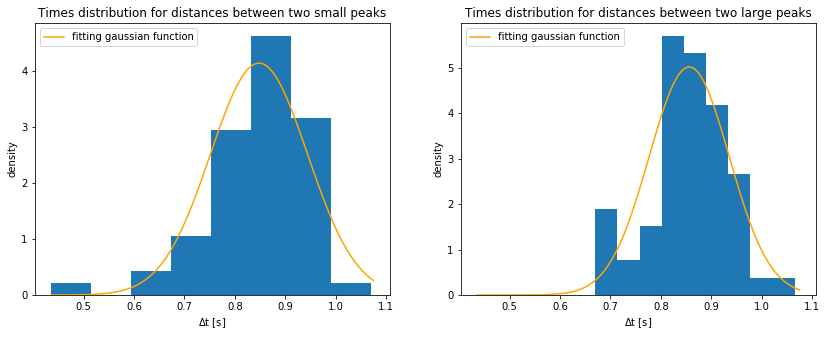

7.306573383990557
-1.359353078263809
3.399485458670891
-0.3533267930638031


In [22]:
x = np.arange( min(min(times_max), min(times_min)), max(max(times_max), max(times_min)) + 0.01, 0.01)

fig, ax = plt.subplots(1, 2, figsize=(14,5))

ax[0].hist(times_min, bins = 8, density = True)
ax[0].plot(x, gauss_min.pdf(x), color = 'orange', label = "fitting gaussian function")
ax[0].set_title("Times distribution for distances between two small peaks")
ax[0].set_xlabel("$\Delta$t [s]")
ax[0].set_ylabel("density")
ax[0].legend()

ax[1].hist(times_max, bins = 9, density = True)
ax[1].plot(x, gauss_max.pdf(x), color = 'orange',  label = "fitting gaussian function")
ax[1].set_title("Times distribution for distances between two large peaks")
ax[1].set_xlabel("$\Delta$t [s]")
ax[1].set_ylabel("density")
ax[1].legend()

plt.show()


print(kurtosis(times_min, axis = 0, fisher = 0))
print(skew(times_min, axis = 0))

print(kurtosis(times_max, axis = 0, fisher = 0))
print(skew(times_max, axis = 0))

In [23]:
chisq_gauss_max  = chisq(times_max, gauss_max.pdf, 2)
chisq_gauss_min  = chisq(times_min, gauss_min.pdf, 2)

print("Parameters of gaussian functions for larger peaks are: ", mu_max, sigma_max )
print("\nChiSquare gauss for max = ", chisq_gauss_max, chi2.cdf(chisq_gauss_max, df = 1), "\n\n\n" )
      
print("Parameters of gaussian functions for smaller peaks are: ",mu_min, sigma_min)
print("\nChiSquare gauss for min = ", chisq_gauss_min, chi2.cdf(chisq_gauss_min, df = 1) )

Parameters of gaussian functions for larger peaks are:  0.8560833333333334 0.07942025175538601

ChiSquare gauss for max =  2.4246592755839287 0.8805607908774751 



Parameters of gaussian functions for smaller peaks are:  0.8479166666666667 0.09635131752544408

ChiSquare gauss for min =  9.524513062457064 0.997972546242193


In [24]:
#since of 

weight_var  = 1/(1/(sigma_max**2)+1/(sigma_min**2))
weight_mean = ( mu_max/(sigma_max**2) + mu_min/(sigma_min**2) ) /(1/(sigma_max**2)+1/(sigma_min**2))


print("Estimation of the time between two heartbeats is : ", weight_mean, "+-", np.sqrt(weight_var))
print("BPM :", 60/weight_mean)

Estimation of the time between two heartbeats is :  0.8527794163891025 +- 0.0612843809388543
BPM : 70.35817099579648


In [25]:
#Define a pdf and then normalize it using parameters found above

import scipy as sp 

lambda_const = 1/weight_mean
mean_value = weight_mean

def normalize(func):
    constant = sp.integrate.quad(func, 0, np.inf)
    return (1/constant[0])

def lambda_norm(diff_time):
    return lambda_const*np.exp(-lambda_const*np.abs(mean_value - diff_time))

def lambda_f(diff_time):
    lambda_const = 1/weight_mean
    mean_value = weight_mean
    const = normalize( lambda_norm )
    return const*lambda_const*np.exp(-lambda_const*np.abs(mean_value - diff_time))

In [26]:
def recomparing_true(dataframe):

   #recompare peaks except for the very first and the very last one
    for index in range(0,len(dataframe)):
        score1, score2 = 0, 0
        
        if dataframe['labels'].iat[index] == -1:
            if index == 0:
                score1 = lambda_f(np.abs( dataframe['Time'].iat[index] - dataframe['Time'].iat[index+1]))
                score2 = lambda_f(np.abs( dataframe['Time'].iat[index] - dataframe['Time'].iat[index+2]))
                if (score2 > score1):
                    dataframe['labels'].iat[index] = dataframe['labels'].iat[index+2]
                    continue
                elif(score2 < score1):
                    dataframe['labels'].iat[index] = dataframe['labels'].iat[index+1]
                    continue
            
            if index == (len(dataframe) - 1):
                score1 = lambda_f( np.abs(dataframe['Time'].iat[index] - dataframe['Time'].iat[index-1]))
                score2 = lambda_f( np.abs(dataframe['Time'].iat[index] - dataframe['Time'].iat[index-2]))
                if (score2 > score1):
                    dataframe['labels'].iat[index] = dataframe['labels'].iat[index-2]
                    continue
                elif(score2 < score1)   :
                    dataframe['labels'].iat[index] = dataframe['labels'].iat[index-1]
                    continue
                    
            
            score1 = lambda_f( np.abs(dataframe['Time'].iat[index] - dataframe['Time'].iat[index-1]))
            score2 = lambda_f( np.abs(dataframe['Time'].iat[index] - dataframe['Time'].iat[index+1]))
            if (score2 > score1) and (score2 > 0.5):
                    dataframe['labels'].iat[index] = dataframe['labels'].iat[index+1]
                    continue
            elif(score2 < score1) and (score1 > 0.5):
                    dataframe['labels'].iat[index] = dataframe['labels'].iat[index-1]
                    continue       
                    
    return dataframe

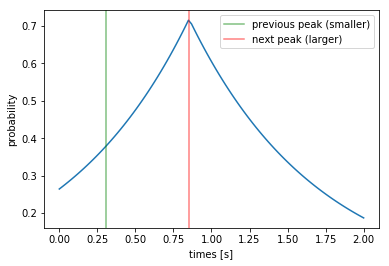

In [27]:
#IT JUST MAKES A PLOT OF THE DISTRIBUTION WE USE FOR WEIGHTS, 

x = np.linspace(0,2,100)
plt.plot(x, lambda_f(x))
plt.axvline(0.3049999999999997, alpha = 0.5, color = 'green', label = "previous peak (smaller)")
plt.axvline(0.8549999999999986, alpha = 0.5, color = 'red', label = "next peak (larger)")
plt.xlabel("times [s]")
plt.ylabel("probability")
plt.legend()
plt.show()

#print(lambda_f(0.3049999999999997),lambda_f(0.8549999999999986))

In [28]:
recompair_df = recomparing_true(maxima_labeled)

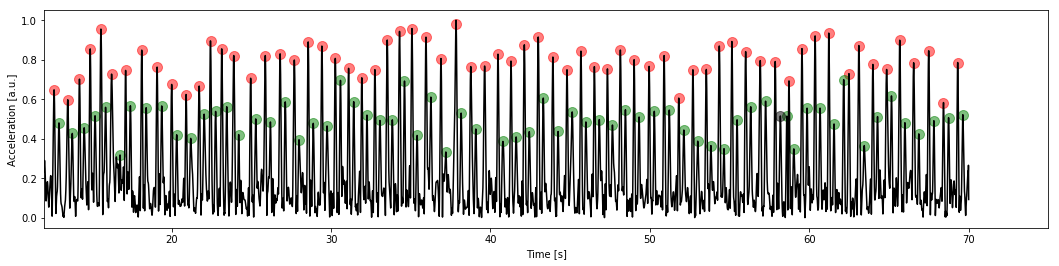

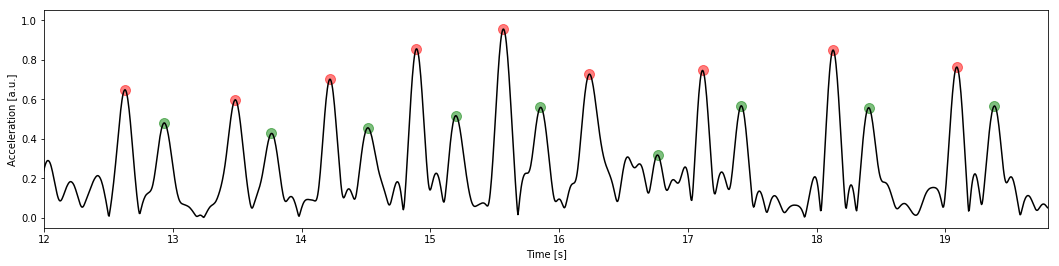

In [29]:
#for plots
large_peaks = recompair_df[recompair_df['labels'] ==  1 ]
small_peaks = recompair_df[recompair_df['labels'] ==  0 ] 
undef_peaks = recompair_df[recompair_df['labels'] == -1 ]

plt.figure
fig = plt.figure(figsize=(18,4))
plt.plot(large_peaks['Time'], large_peaks['max'], 'ro', markersize = 10, alpha = 0.5)
plt.plot(small_peaks['Time'], small_peaks['max'], 'go', markersize = 10, alpha = 0.5)
plt.plot(undef_peaks['Time'], undef_peaks['max'], 'ko', markersize = 10, alpha = 0.5)
plt.plot(Filtered['Time'],Filtered["Amp_envelope"],'k',label='envelope')
plt.xlim([12,75])
plt.ylabel('Acceleration [a.u.]')
plt.xlabel("Time [s]")
plt.show()

plt.figure
fig = plt.figure(figsize=(18,4))
plt.plot(large_peaks['Time'], large_peaks['max'], 'ro', markersize = 10, alpha = 0.5)
plt.plot(small_peaks['Time'], small_peaks['max'], 'go', markersize = 10, alpha = 0.5)
plt.plot(undef_peaks['Time'], undef_peaks['max'], 'ko', markersize = 10, alpha = 0.5)
plt.plot(Filtered['Time'],Filtered["Amp_envelope"],'k',label='envelope')
plt.ylabel('Acceleration [a.u.]')
plt.xlabel("Time [s]")
plt.xlim([12,19.8])
plt.show()

In [30]:
times_max_new, times_min_new = compute_times(recompair_df)

In [31]:
print(np.mean(times_max_new),' +/- ', np.std(times_max_new))
print(np.mean(times_min_new), ' +/- ', np.std(times_min_new))

0.8562903225806451  +/-  0.07814861505733685
0.8486885245901639  +/-  0.09574514343435829


In [32]:
###Fit using gamma and gauss functions, then instantiate them
###For max
(mu_max_new, sigma_max_new) = norm.fit(times_max_new)
gauss_max_new = norm(loc = mu_max_new, scale = sigma_max_new)

#for min
(mu_min_new, sigma_min_new) = norm.fit(times_min_new)
gauss_min_new = norm(loc = mu_min_new, scale = sigma_min_new)


#compute chi square and print results
chisq_gauss_max_new  = chisq( times_max_new , gauss_max_new.pdf, 2) 
chisq_gauss_min_new  = chisq( times_min_new , gauss_min_new.pdf, 2)

print("Parameters of gaussian functions for new larger peaks are: ", mu_min_new, sigma_min_new)
print("\nChiSquare gauss = ", chisq_gauss_max_new, chi2.cdf(chisq_gauss_max_new, df = 1), "\n\n\n" )

print("Parameters of gaussian functions for new smaller peaks are: ", mu_max_new, sigma_max_new)
print("\nChiSquare gauss = ", chisq_gauss_min_new, chi2.cdf(chisq_gauss_min_new, df = 1), "\n\n\n" )

Parameters of gaussian functions for new larger peaks are:  0.8486885245901639 0.09574514343435829

ChiSquare gauss =  2.5120901951129793 0.8870240033502724 



Parameters of gaussian functions for new smaller peaks are:  0.8562903225806451 0.07814861505733685

ChiSquare gauss =  10.59252665005777 0.9988645430356571 





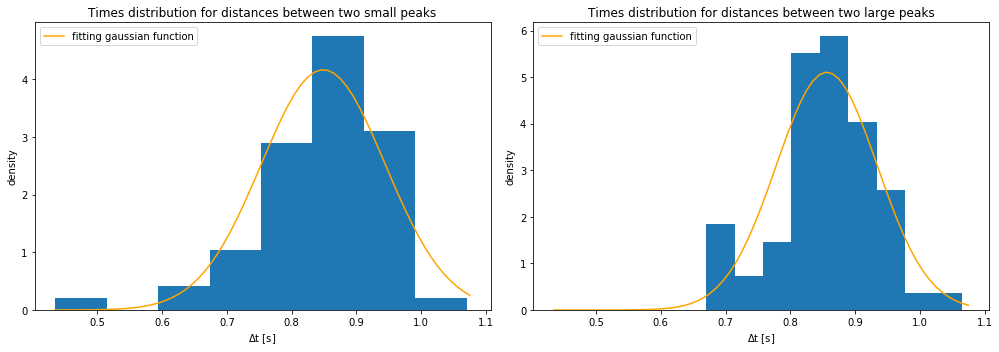

7.4157565021225675
-1.3848609482866787
3.513096242541512
-0.36674884141519076


In [33]:
x = np.arange( min(min(times_max_new), min(times_min_new)), max(max(times_max_new), max(times_min_new)) + 0.01, 0.01)

fig, ax = plt.subplots(1, 2, figsize=(14,5))

ax[0].hist(times_min_new, bins = 8, density = True)
ax[0].plot(x, gauss_min_new.pdf(x), color = 'orange', label = "fitting gaussian function")
ax[0].set_title("Times distribution for distances between two small peaks")
ax[0].set_xlabel("$\Delta$t [s]")
ax[0].set_ylabel("density")
ax[0].legend()

ax[1].hist(times_max_new, bins = 9, density = True)
ax[1].plot(x, gauss_max_new.pdf(x), color = 'orange',  label = "fitting gaussian function")
ax[1].set_title("Times distribution for distances between two large peaks")
ax[1].set_xlabel("$\Delta$t [s]")
ax[1].set_ylabel("density")
ax[1].legend()

plt.tight_layout()
plt.show()

print(kurtosis(times_min_new, axis = 0, fisher = 0))
print(skew(times_min_new, axis = 0))

print(kurtosis(times_max_new, axis = 0, fisher = 0))
print(skew(times_max_new, axis = 0))

In [34]:
weight_var  = 1/(1/(sigma_max_new**2)+1/(sigma_min_new**2))
weight_mean = ( mu_max_new/(sigma_max_new**2) + mu_min_new/(sigma_min_new**2) ) /(1/(sigma_max_new**2)+1/(sigma_min_new**2))


print("Final estimation of the time between two heartbeats is : ", weight_mean, "+-", np.sqrt(weight_var))
print("BPM :", 60/weight_mean)
print('The std of BPM', 60/(weight_mean**2)* np.sqrt(weight_var))

Final estimation of the time between two heartbeats is :  0.8532508622147368 +- 0.060542009815365894
BPM : 70.3192960675847
The std of BPM 4.989472265733158


# HRV
We can either use the sigma of the fitting distribution, or scatter plot

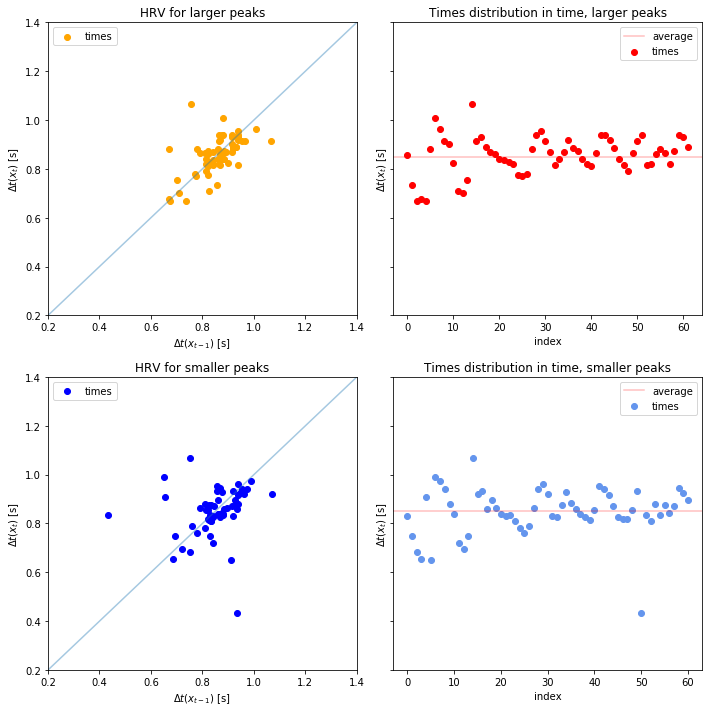

In [35]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharey=True)

x = np.linspace(0, 2,100)
#x = np.linspace(0.2, max(times_max_new) + 0.1,100)
ax[0,0].scatter(times_max_new[:-1], times_max_new[1:], color = 'orange', label = "times")
ax[0,0].set_title("HRV for larger peaks")
ax[0,0].set_xlabel("$\Delta t (x_{t-1})$ [s]")
ax[0,0].set_ylabel("$\Delta t (x_{t})$ [s]")
ax[0,0].plot(x,x, alpha = 0.4)
ax[0,0].axis([0.2,1.4,0.2,1.4])
ax[0,0].legend()

ax[0,1].scatter(np.arange(len(times_max_new)), times_max_new, color = 'red', label = "times")
ax[0,1].axhline(0.85, color = 'red', alpha = 0.25, label = 'average')
ax[0,1].set_title("Times distribution in time, larger peaks")
ax[0,1].set_xlabel("index")
ax[0,1].set_ylabel("$\Delta t (x_{t})$ [s]")
ax[0,1].legend()

#x = np.linspace(0.2, max(times_min_new)+0.1,100)
ax[1,0].scatter(times_min_new[:-1], times_min_new[1:], color = 'blue', label = "times")
ax[1,0].set_title("HRV for smaller peaks")
ax[1,0].set_xlabel("$\Delta t (x_{t-1})$ [s]")
ax[1,0].set_ylabel("$\Delta t (x_{t})$ [s]")
ax[1,0].plot(x,x, alpha = 0.4)
ax[1,0].axis([0.2,1.4,0.2,1.4])
ax[1,0].legend()

ax[1,1].scatter(np.arange(len(times_min_new)), times_min_new, color = 'cornflowerblue', label = "times")
ax[1,1].axhline(0.85, color = 'red', alpha = 0.25, label = 'average')
ax[1,1].set_title("Times distribution in time, smaller peaks")
ax[1,1].set_xlabel("index")
ax[1,1].set_ylabel("$\Delta t (x_{t})$ [s]")
ax[1,1].legend()

plt.tight_layout()
plt.savefig('HRV_ACC_Z.png', bbox_inches = "tight")

#### PCA (Principal Component Analysis )


In [36]:
data_a_g = data_small_ag.iloc[:,4:7]-data_small_ag.iloc[:,4:7].mean() 

In [37]:
matrix_cov_gyr = np.cov(data_a_g, rowvar=False) #covariance matrix
l1, V1 = np.linalg.eig(matrix_cov_gyr) #also eigenvalues and eigenvectors

In [38]:
Lambda1=np.diag(l1) #diagonal matrix with the eigenvectors, sorted by their module (default in python)
#print(Lambda1)

In [39]:
print('Gyroscope')
print('Cov matrix trace:', matrix_cov_gyr.trace())
print('Diagonal matrix of the eigenvalues trace:' ,Lambda1.trace())
perc_expl11 = Lambda1[0,0]/Lambda1.trace()
print('Percent of the total variability explained considering only the first component: ',np.round(perc_expl11*100),'%')
perc_expl12 = (Lambda1[0,0]+ Lambda1[1,1])/Lambda1.trace()
print('Percent of the total variability explained considering the first two components: ', np.round(perc_expl12*100),'%')
perc_expl13 = (Lambda1[1,1]+ Lambda1[2,2])/Lambda1.trace()
print('Percent of the total variability explained considering the second two components: ', np.round(perc_expl13*100),'%')


Gyroscope
Cov matrix trace: 2.636273565089039
Diagonal matrix of the eigenvalues trace: 2.636273565089038
Percent of the total variability explained considering only the first component:  80.0 %
Percent of the total variability explained considering the first two components:  96.0 %
Percent of the total variability explained considering the second two components:  20.0 %


In [40]:
W1=V1[0:2] # W1 is the matrix of the first 2 eigenvectors for Gyr 
print(W1, '\n')
Cp_gyr = np.dot(W1,data_a_g.T) # Cp_gyr are the original data projected in the subspace generated by the two main eigenvectors
print(Cp_gyr)

[[ 0.96317916  0.26290735 -0.05626402]
 [ 0.2457237  -0.94573079 -0.21263381]] 

[[ 4.04779196  3.65534057  3.08540445 ... -0.89329237 -0.89374688
  -0.81028536]
 [-0.33636352  0.45298752  0.18691254 ... -0.28766874 -0.39299679
   0.06297054]]


In [41]:
a = Cp_gyr[0:1].T
b = Cp_gyr[1:2].T
CP_g1 = np.array(a)
CP_g2 = np.array(b)
principal = {
    'cp_g1': CP_g1.flatten(),
    'cp_g2': CP_g2.flatten(),
}

pc = pd.DataFrame(principal)  #pc is the dataframe with the two principal components
#pc

# FFT analysis & filter

Text(0.5,0,'Frequency [Hz]')

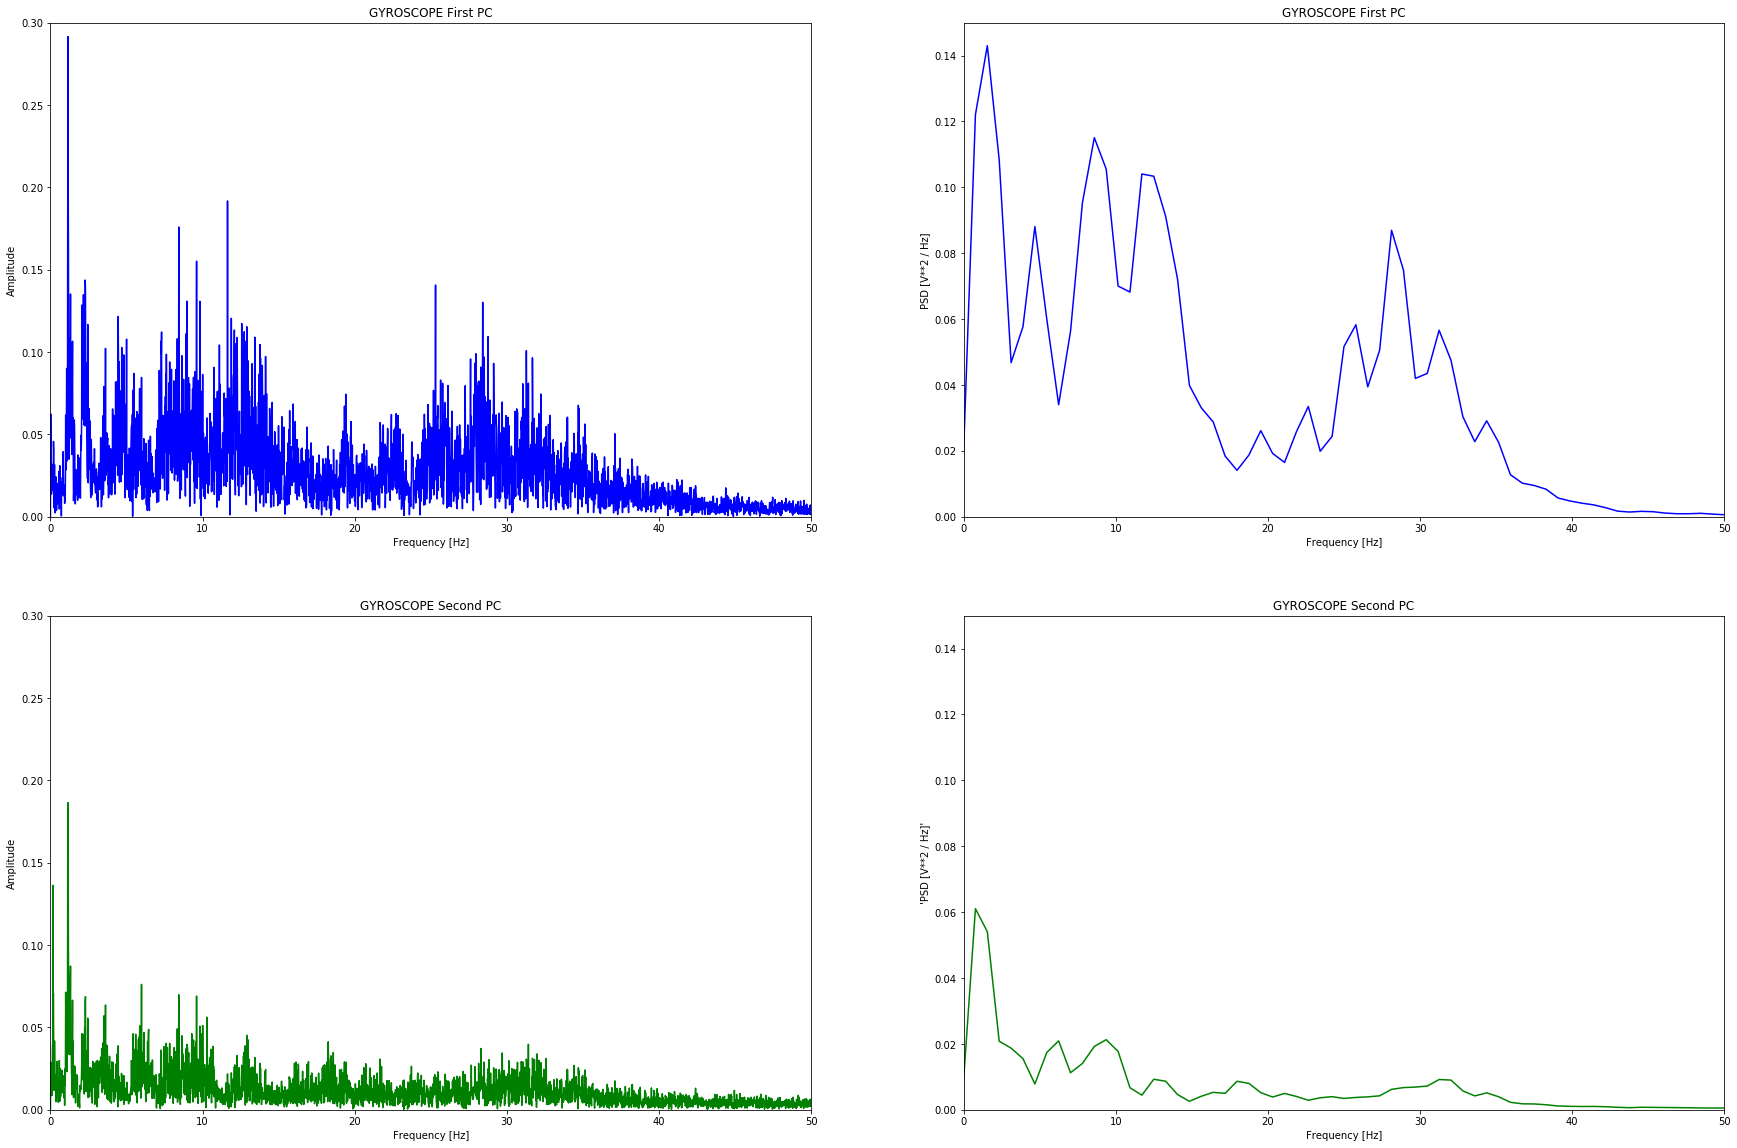

In [42]:
N = pc.shape[0]
T = 1/Freq   
f_s = Freq   

f_values, fft_values = get_fft_values(pc['cp_g1'], T, N, f_s)
f_values_psd, psd_values = get_psd_values(pc['cp_g1'], T, N, f_s)

f_values_g, fft_values_g = get_fft_values(pc['cp_g2'], T, N, f_s)
f_values_psd_g, psd_values_g = get_psd_values(pc['cp_g2'], T, N, f_s)

#PLOTTING
fig, axs = plt.subplots(2,2,figsize = (30,20))
axs[0,0].plot(f_values,fft_values,'b')
axs[0,0].set_title( "GYROSCOPE First PC")
axs[0,0].axis([0,50,0,0.3])
axs[0,0].set_ylabel("Amplitude")
axs[0,0].set_xlabel('Frequency [Hz]')
axs[0,1].plot(f_values_psd, psd_values, linestyle='-', color='blue')
axs[0,1].set_title("GYROSCOPE First PC")
axs[0,1].axis([0,50,0,0.15])
axs[0,1].set_ylabel("PSD [V**2 / Hz]")
axs[0,1].set_xlabel('Frequency [Hz]')
##############################################
axs[1,0].plot(f_values_g,fft_values_g,'g')
axs[1,0].set_title( "GYROSCOPE Second PC")
axs[1,0].axis([0,50,0,0.3])
axs[1,0].set_ylabel("Amplitude")
axs[1,0].set_xlabel('Frequency [Hz]')
axs[1,1].plot(f_values_psd_g, psd_values_g, linestyle='-', color='g')
axs[1,1].axis([0,50,0,0.15])
axs[1,1].set_title("GYROSCOPE Second PC")
axs[1,1].set_ylabel("'PSD [V**2 / Hz]'")
axs[1,1].set_xlabel('Frequency [Hz]')
##############################################

#plt.savefig('3_FFT_data_gyro.png', bbox_inches = "tight")

Text(0.5,0,'Frequency [Hz]')

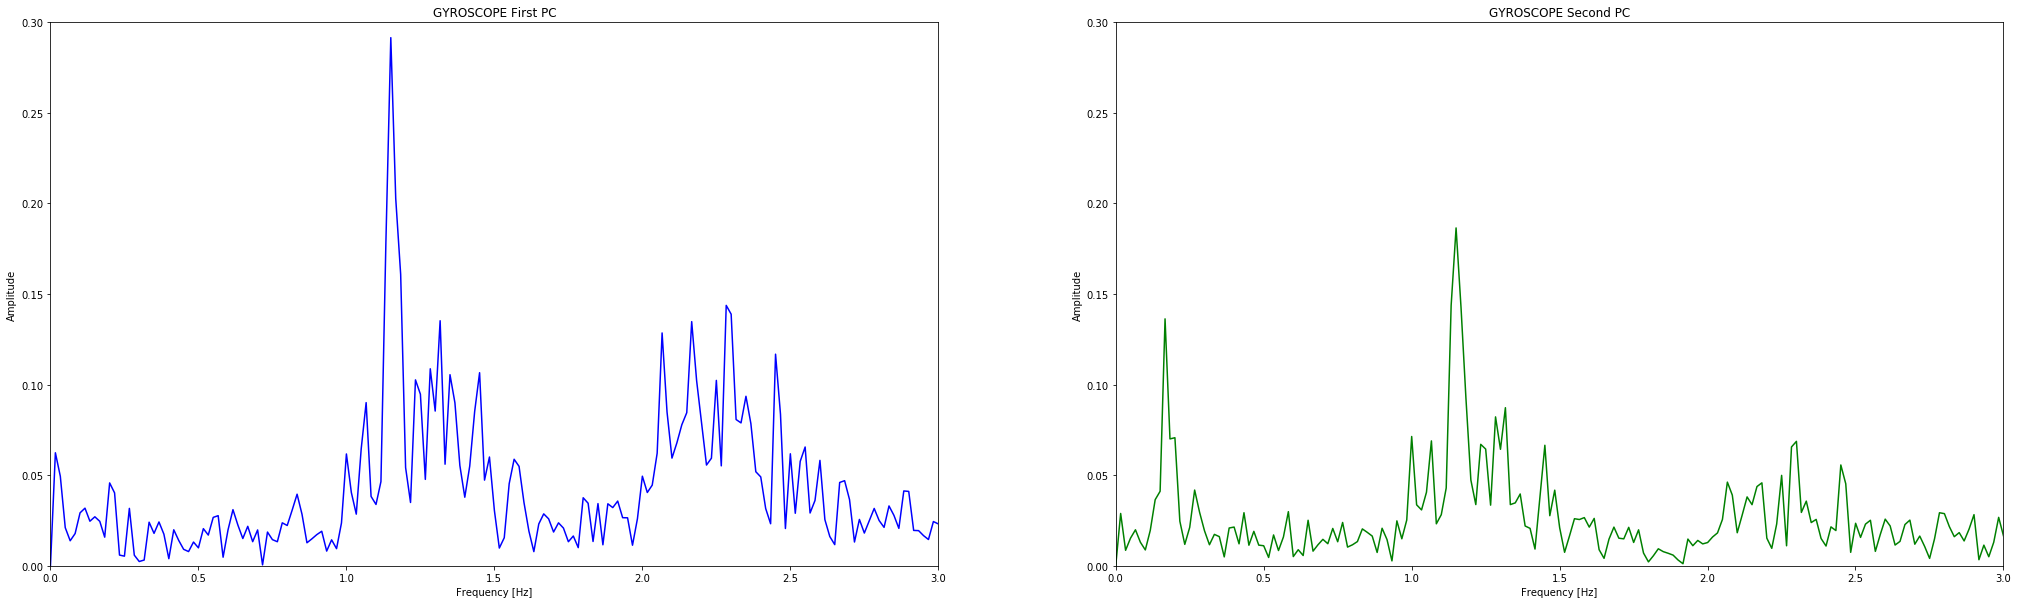

In [43]:
#PLOTTING ZOOM
fig, axs = plt.subplots(1,2,figsize = (35,10))
axs[0].plot(f_values,fft_values,'b')
axs[0].set_title( "GYROSCOPE First PC")
axs[0].axis([0,3,0,0.3])
axs[0].set_ylabel("Amplitude")
axs[0].set_xlabel('Frequency [Hz]')
##############################################
axs[1].plot(f_values_g,fft_values_g,'g')
axs[1].set_title( "GYROSCOPE Second PC")
axs[1].axis([0,3,0,0.3])
axs[1].set_ylabel("Amplitude")
axs[1].set_xlabel('Frequency [Hz]')
#plt.savefig('4_FFT_data_gyro_zoom.png', bbox_inches = "tight")

## First Principal Component Analysis

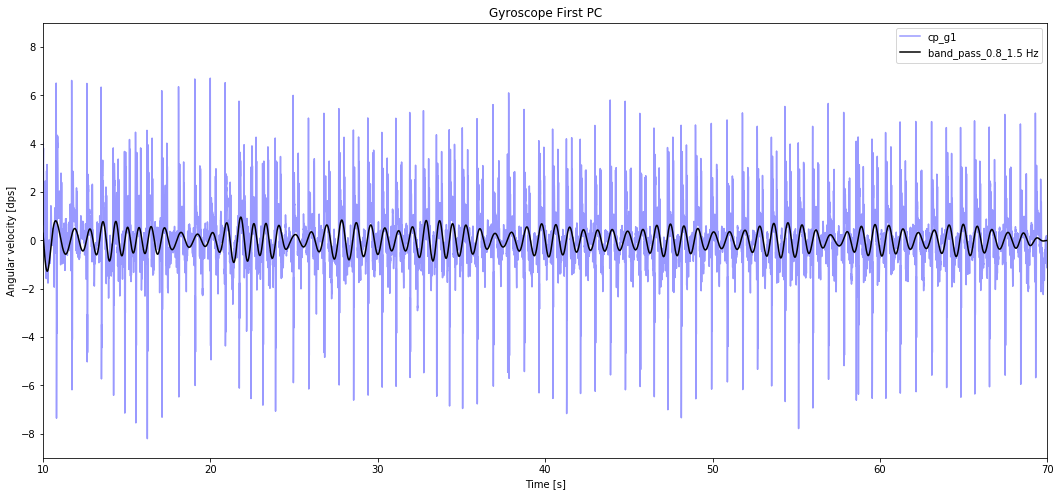

In [44]:
result_2 = my_filter(3, [0.8,1.5] , 'band', 200, pc['cp_g1'])

massimi_x_gyro = maxima_minima(data_small_ag['Time'].values, result_2) #looks at maxima

#look at time distance between max
tempi_massimi_x_gyro = find_max(massimi_x_gyro)

plt.figure
fig= plt.figure(figsize=(18,8))
plt.plot(data_small_ag['Time'],pc['cp_g1'],'b', alpha = 0.4)
plt.plot(data_small_ag['Time'], result_2,'k',label='band_pass_0.8_1.5 Hz')
#plt.plot(data_small_ag['Time'], result_10 + mean_ampl_gyrx,'r',label='band_pass_0.3_1.5 Hz')
plt.xlabel('Time [s]')
plt.ylabel('Angular velocity [dps]')
plt.title('Gyroscope First PC')
plt.ylim([-9,9])
plt.xlim([10,70])
plt.legend()
plt.savefig('correct1.png', bbox_inches = "tight")

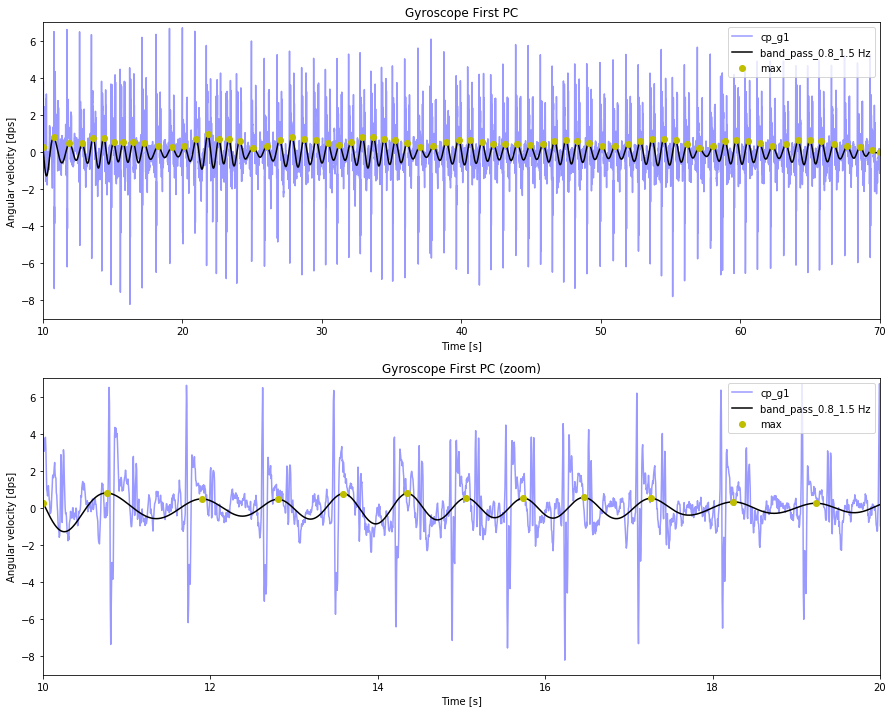

In [45]:
fig, axs = plt.subplots(2,1,figsize = (15,12))

######################################################################
axs[0].plot(data_small_ag['Time'],pc['cp_g1'],'b', alpha = 0.4)
axs[0].plot(data_small_ag['Time'], result_2,'k',label='band_pass_0.8_1.5 Hz')
axs[0].axis([10,70,-9,7])
axs[0].plot(massimi_x_gyro['Time'], massimi_x_gyro['max'], 'oy')
axs[0].set_ylabel("Angular velocity [dps]")
axs[0].set_xlabel('Time [s]')
axs[0].set_title('Gyroscope First PC')
axs[0].legend(loc='upper right')
######################################################################
axs[1].plot(data_small_ag['Time'],pc['cp_g1'],'b', alpha = 0.4)
axs[1].plot(data_small_ag['Time'], result_2,'k',label='band_pass_0.8_1.5 Hz')
axs[1].axis([10,20,-9,7])
axs[1].plot(massimi_x_gyro['Time'], massimi_x_gyro['max'], 'oy')
axs[1].set_ylabel("Angular velocity [dps]")
axs[1].set_xlabel('Time [s]')
axs[1].set_title('Gyroscope First PC (zoom)')
axs[1].legend(loc='upper right')
#plt.savefig('5_max_gyro_x.png', bbox_inches = "tight")
plt.savefig('correct2.png', bbox_inches = "tight")

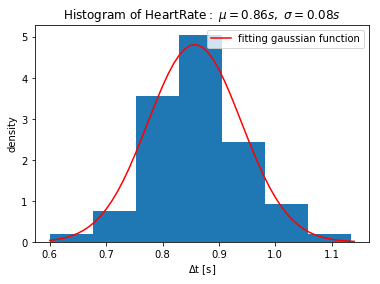

In [46]:
x = np.arange( min(min(tempi_massimi_x_gyro['Time'].values), min(tempi_massimi_x_gyro['Time'].values)), max(max(tempi_massimi_x_gyro['Time'].values), max(tempi_massimi_x_gyro['Time'].values)) + 0.01, 0.01)
(mu_1, sigma_1) = norm.fit(tempi_massimi_x_gyro['Time'])
gauss = norm(loc = mu_1, scale = sigma_1)
plt.hist(tempi_massimi_x_gyro['Time'], bins = 7, density = True)
plt.plot(x, gauss.pdf(x), color = 'red', label = "fitting gaussian function")
plt.xlabel("$\Delta$t [s]")
plt.ylabel("density")
plt.title('$\mathrm{Histogram\ of\ Heart Rate:}\ \mu=%.2f s,\ \sigma=%.2f s$' %(mu_1, sigma_1))
plt.legend()
plt.show()

In [47]:
skew(tempi_massimi_x_gyro['Time'], axis=0)

0.09610658820309045

In [48]:
# kurtosis is < 3 so the distribution is mesokurtic
kurtosis(tempi_massimi_x_gyro['Time'], axis=0, fisher=0)

4.54978339773769

## Second Principal Component Analysis

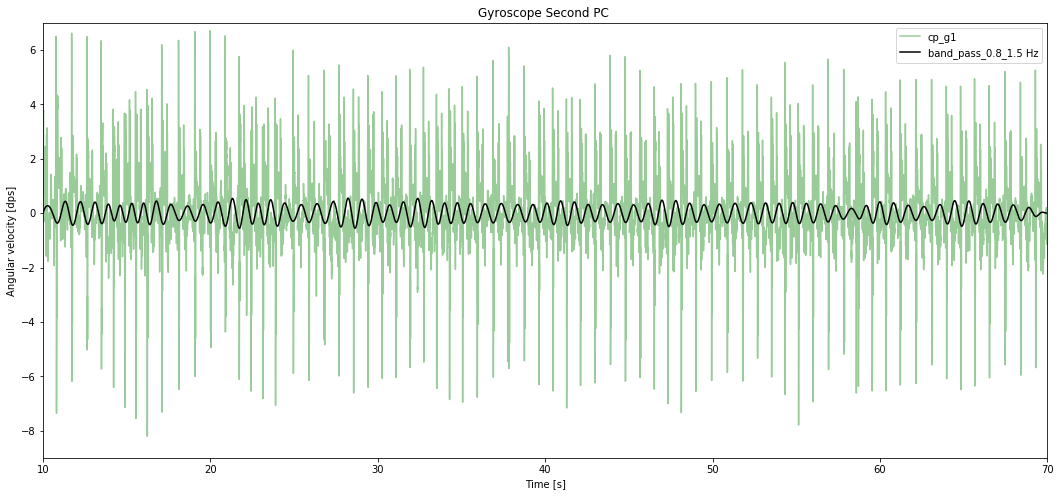

In [49]:
result_2y = my_filter(3, [0.8,1.5] , 'band', 200, pc['cp_g2'])

massimi_y_gyro = maxima_minima(data_small_ag['Time'].values, result_2y) #looks at maxima

#look at time distance between max
tempi_massimi_y_gyro = find_max(massimi_y_gyro)


plt.figure
fig= plt.figure(figsize=(18,8))
plt.plot(data_small_ag['Time'],pc['cp_g1'],'g', alpha = 0.4)
plt.plot(data_small_ag['Time'], result_2y,'k',label='band_pass_0.8_1.5 Hz')
#plt.plot(data_small_ag['Time'], result_1, 'r',label='band_pass_0.3_1.5 Hz')
plt.xlabel('Time [s]')
plt.ylabel('Angular velocity [dps]')
plt.title('Gyroscope Second PC ')
plt.ylim([-9,7])
plt.xlim([10,70])
plt.legend()
plt.savefig('correct3.png', bbox_inches = "tight")

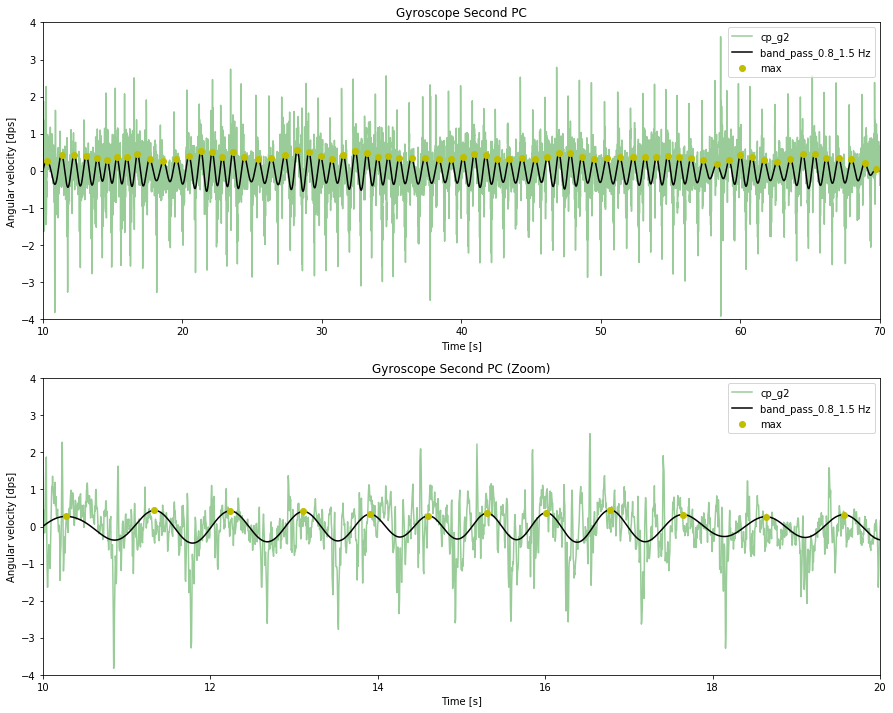

In [50]:
fig, axs = plt.subplots(2,1,figsize = (15,12))


######################################################################
axs[0].plot(data_small_ag['Time'],pc['cp_g2'],'g', alpha = 0.4)
axs[0].plot(data_small_ag['Time'], result_2y,'k',label='band_pass_0.8_1.5 Hz')
axs[0].axis([10,70,-4,4])
axs[0].plot(massimi_y_gyro['Time'], massimi_y_gyro['max'], 'oy')
axs[0].set_ylabel("Angular velocity [dps]")
axs[0].set_xlabel('Time [s]')
axs[0].set_title('Gyroscope Second PC')
axs[0].legend(loc = 'upper right')
######################################################################
axs[1].plot(data_small_ag['Time'],pc['cp_g2'],'g', alpha = 0.4)
axs[1].plot(data_small_ag['Time'], result_2y,'k',label='band_pass_0.8_1.5 Hz')
axs[1].axis([10,20,-4,4])
axs[1].plot(massimi_y_gyro['Time'], massimi_y_gyro['max'], 'oy')
axs[1].set_ylabel("Angular velocity [dps]")
axs[1].set_xlabel('Time [s]')
axs[1].set_title('Gyroscope Second PC (Zoom)')
axs[1].legend(loc = 'upper right')
plt.savefig('correct4.png', bbox_inches = "tight")

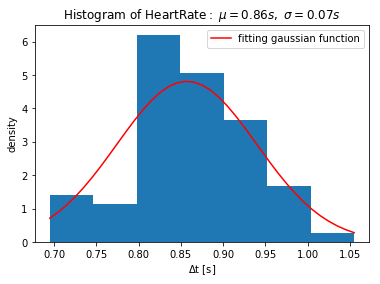

In [51]:
x = np.arange( min(min(tempi_massimi_y_gyro['Time'].values), min(tempi_massimi_y_gyro['Time'].values)), max(max(tempi_massimi_y_gyro['Time'].values), max(tempi_massimi_y_gyro['Time'].values)) + 0.01, 0.01)
(mu_2, sigma_2) = norm.fit(tempi_massimi_y_gyro['Time'])
gauss = norm(loc = mu_1, scale = sigma_1)
plt.hist(tempi_massimi_y_gyro['Time'], bins = 7, density = True)
plt.plot(x, gauss.pdf(x), color = 'red', label = "fitting gaussian function")
plt.xlabel("$\Delta$t [s]")
plt.ylabel("density")
plt.title('$\mathrm{Histogram\ of\ Heart Rate:}\ \mu=%.2f s,\ \sigma=%.2f s$' %(mu_2, sigma_2))
plt.legend()
plt.show()

In [52]:
skew(tempi_massimi_y_gyro['Time'], axis=0)

0.01985148706684997

In [53]:
# kurtosis is < 3 so the distribution is mesokurtic
kurtosis(tempi_massimi_y_gyro['Time'], axis=0, fisher = 0)

2.9436829027957954

## Compatibility and final estimation of HRV

In [54]:
# compatibilità
comp = (np.abs(mu_1 - mu_2))/np.sqrt(sigma_1**2 + sigma_2**2)
comp

0.03830758662704686

In [55]:
#media pesata
K=1/(sigma_1**2)+1/(sigma_2**2)
mu_final = ((mu_1/sigma_1**2)+(mu_2/sigma_2**2))/K
sigma_final = np.sqrt(1/K)
print('The final estimation of HRV is ', mu_final , sigma_final)
print('BPM:', 60/mu_final)
print('The std of BPM',(60/(mu_final)**2)*sigma_final)

The final estimation of HRV is  0.8594557229642287 0.05480491911456012
BPM: 69.81162426036606
The std of BPM 4.451678333875807


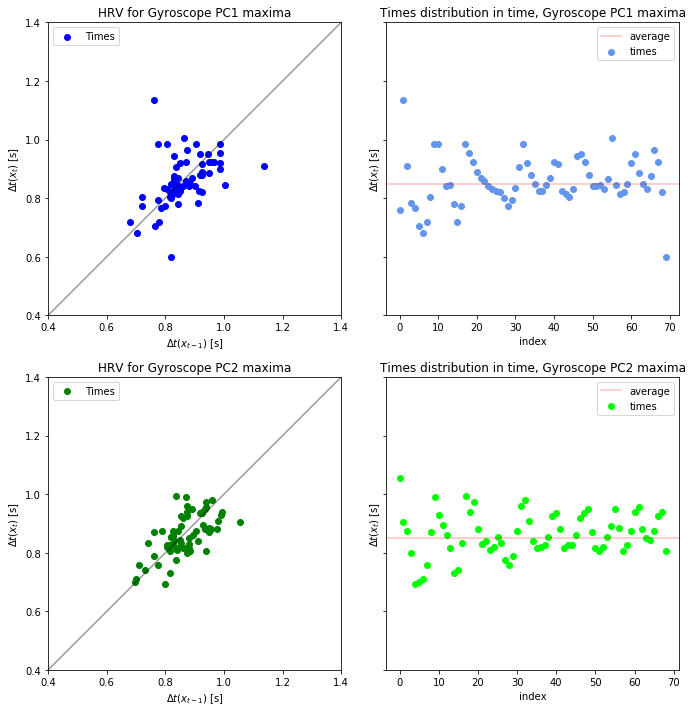

In [56]:
x = np.linspace(0, 2,100)

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharey = True)

ax[0,0].scatter(tempi_massimi_x_gyro['Time'].values[:-1], tempi_massimi_x_gyro['Time'].values[1:], color = 'b', label = "Times")
ax[0,0].set_title("HRV for Gyroscope PC1 maxima")
ax[0,0].set_xlabel("$\Delta t (x_{t-1})$ [s]")
ax[0,0].set_ylabel("$\Delta t (x_{t})$ [s]")
ax[0,0].plot(x,x,'k', alpha = 0.4)
ax[0,0].axis([0.4,1.4,0.4,1.4])
ax[0,0].legend()

ax[0,1].scatter(np.arange(len(tempi_massimi_x_gyro['Time'])), tempi_massimi_x_gyro['Time'], color = 'cornflowerblue', label = "times")
ax[0,1].axhline(0.85, color = 'red', alpha = 0.25, label = 'average')
ax[0,1].set_title("Times distribution in time, Gyroscope PC1 maxima")
ax[0,1].set_xlabel("index")
ax[0,1].set_ylabel("$\Delta t (x_{t})$ [s]")
ax[0,1].legend()

#############################################################################################
ax[1,0].scatter(tempi_massimi_y_gyro['Time'].values[:-1], tempi_massimi_y_gyro['Time'].values[1:], color = 'g', label = "Times")
ax[1,0].set_title("HRV for Gyroscope PC2 maxima")
ax[1,0].set_xlabel("$\Delta t (x_{t-1})$ [s]")
ax[1,0].set_ylabel("$\Delta t (x_{t})$ [s]")
ax[1,0].axis([0.4,1.4,0.4,1.4])
ax[1,0].plot(x,x, 'k', alpha = 0.4)
ax[1,0].legend()


ax[1,1].scatter(np.arange(len(tempi_massimi_y_gyro['Time'])), tempi_massimi_y_gyro['Time'], color = 'lime', label = "times")
ax[1,1].axhline(0.85, color = 'red', alpha = 0.25, label = 'average')
ax[1,1].set_title("Times distribution in time, Gyroscope PC2 maxima")
ax[1,1].set_xlabel("index")
ax[1,1].set_ylabel("$\Delta t (x_{t})$ [s]")
ax[1,1].legend()

plt.tight_layout()
plt.show()

### CONCLUSION